#### **Which advertising channel has the strongest relationship with sales volume, and can be reliably used to model and predict future sales?**

This project aims to answer that question by applying linear regression modeling to advertising spend data across multiple channels - including TV, radio, and newspapers. 

By analyzing the strength and significance of each channel’s contribution to sales, we can identify which medium drives the most impact and holds the most predictive value.

The dataset contains the following columns:

- **sales**: the number of widgets sold (in thousands)  
- **tv**: the amount of money (in thousands of dollars) spent on TV ads  
- **radio**: the amount of money (in thousands of dollars) spent on radio ads  
- **newspaper**: the amount of money (in thousands of dollars) spent on newspaper ads

In [262]:
# Mathematical computation and data manipulation libraries
import numpy as np
import pandas as pd

# Visualisation libraries
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Machine learning libraries
import statsmodels.api as sm
import scipy.stats as stats

In [263]:
# Load data
df_ad = pd.read_csv("advertising.csv", index_col = 0)

# First 5 rows
df_ad.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [264]:
# Last 5 rows
df_ad.tail()

,TV,radio,newspaper,sales
196,38.2,3.7,13.8,7.6
197,94.2,4.9,8.1,9.7
198,177.0,9.3,6.4,12.8
199,283.6,42.0,66.2,25.5
200,232.1,8.6,8.7,13.4


In [265]:
# Get metadata
df_ad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [266]:
# See number of rows and columns
print(f"The dataset has {df_ad.shape[0]} rows and {df_ad.shape[1]} columns.")

# Check for duplicates
print("\nDuplicates:", df_ad.duplicated().sum())

# Rename columns
df_ad.columns = df_ad.columns.str.title()
df_ad.rename(columns = {"Tv": "TV"}, inplace = True)

# Preview new column names
print("\nModified column names:")
df_ad.sample(7)

The dataset has 200 rows and 4 columns.

Duplicates: 0

Modified column names:


,TV,Radio,Newspaper,Sales
67,31.5,24.6,2.2,9.5
140,184.9,43.9,1.7,20.7
100,135.2,41.7,45.9,17.2
99,289.7,42.3,51.2,25.4
114,209.6,20.6,10.7,15.9
190,18.7,12.1,23.4,6.7
55,262.7,28.8,15.9,20.2


In [267]:
# Get basic statistical info
df_ad.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


### Summary Statistics

- **Sample Size**: 200 observations across all variables

#### TV Advertising
- **Mean**: $147k - average spend is the highest among the three channels.
- **Std Dev**: ~85.85 - wide variation in spend across campaigns.
- **Range**: $0.7k to \$296.4k - some campaigns barely use TV, while others rely heavily on it.

#### Radio Advertising
- **Mean**: $23.26k - much lower average spend compared to TV.
- **Std Dev**: ~14.85 - moderate variability across campaigns.
- **Range**: $0 to \$49.6k - some campaigns skip radio entirely.

#### Newspaper Advertising
- **Mean**: $30.55k - slightly higher average spend than radio, but with the **widest spread**.
- **Std Dev**: ~21.78 - spending here is more inconsistent.
- **Range**: $0.3k to $114k - shows some outliers or heavier newspaper-focused strategies.

#### Sales (Target Variable)
- **Mean**: 14.02 units - average number of units sold.
- **Std Dev**: ~5.22 - some variability in sales performance.
- **Range**: 1.6 to 27.0 units - reflects both low- and high-performing campaigns.

**Quick Take**: TV gets the most budget and shows the highest variability. Radio is more conservative and consistent, while newspaper has a wide, somewhat erratic spread. Sales vary moderately, with some campaigns performing very well.

Check for outliers

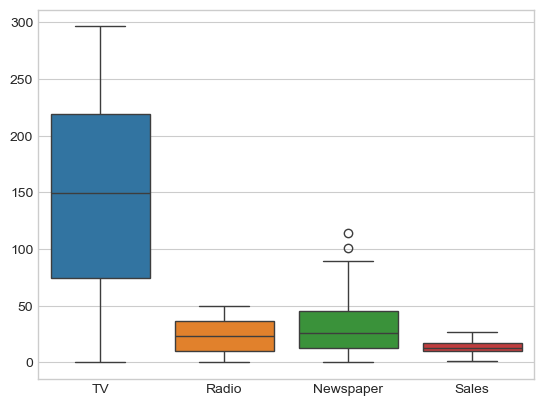

In [268]:
sns.boxplot(df_ad);

> Only the Newspapers column appears to have outliers.

> However, these are genuine outliers so we keep them.

#### Using scatter plots to plot each predictor (TV, Radio, Newspaper) against the target variable.

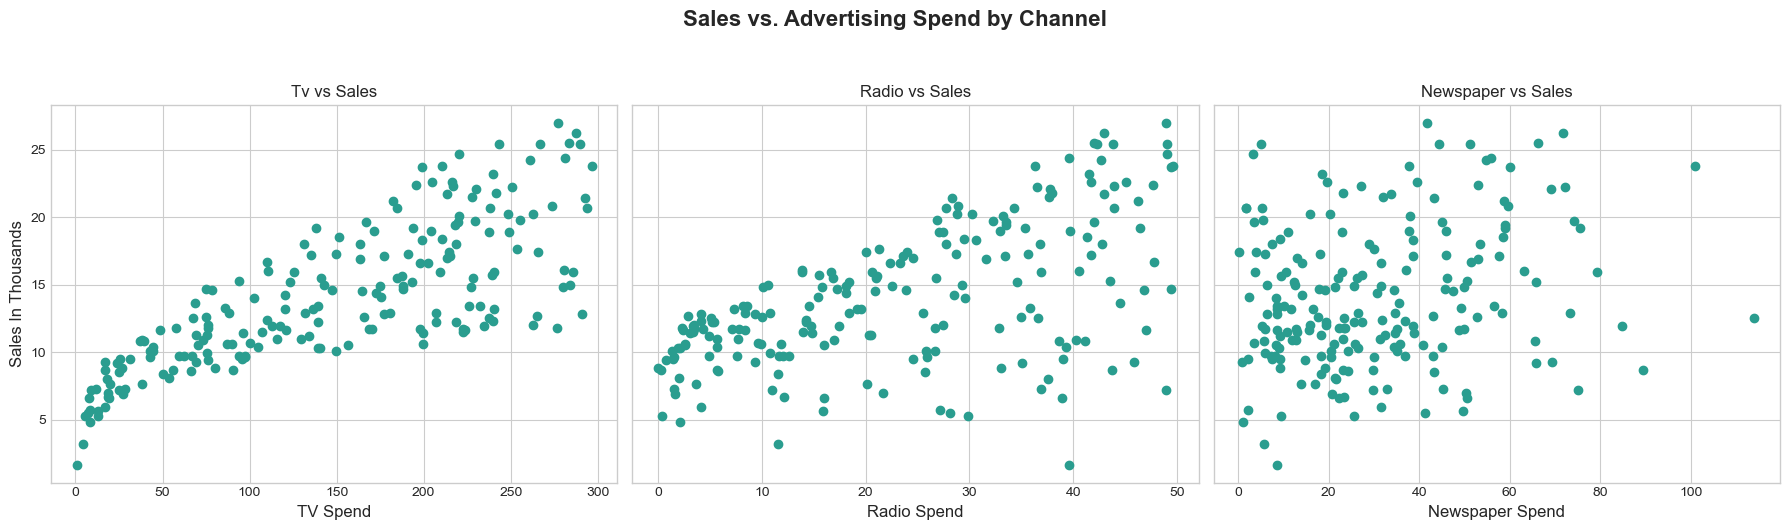

In [269]:
# Visualising the predictors against the target using scatter plots

# Define the predictor variables
predictors = ['TV', 'Radio', 'Newspaper']

# Create subplots: 1 row, 3 columns
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 5), sharey = True)

# Plot scatter plots
for i, predictor in enumerate(predictors):
    axes[i].scatter(df_ad[predictor], df_ad['Sales'], color = '#2a9d8f')
    axes[i].set_title(f'{predictor.capitalize()} vs Sales')
    axes[i].set_xlabel(f'{predictor} Spend', fontsize = 12)
    if i == 0:
        axes[i].set_ylabel('Sales In Thousands', fontsize = 12)

# Title
fig.suptitle('Sales vs. Advertising Spend by Channel', fontsize = 16, weight = 'bold', y = 1.05)
plt.tight_layout()
plt.show()

### Comment on the linearity of the predictors against the target

> TV seems to be a good predictor because it has the most linear relationship with sales.

> Radio also seems to have a linear relationship, but there is more variance than with TV. We would expect a model using Radio to be able to predict the target, but not as well as a model using TV.

> Newspaper has the least linear-looking relationship. There is a lot of variance as well. It's not clear from this plot whether a model using newspaper would be able to predict the target.


## TV
### Simple Linear Regression with TV as the Predictor

In [270]:
# Get regression line using Least Squares Method

# Calculate the correlation coefficient
rho = np.corrcoef(df_ad["Sales"], df_ad["TV"])[0][1]

# Calculate standard deviations and slope
s_y = df_ad["Sales"].std()
s_x = df_ad["TV"].std()
m = rho * s_y / s_x

# Calculate the intercept
mean_y = df_ad["Sales"].mean()
mean_x = df_ad["TV"].mean()
c = mean_y - m * mean_x

print(f"TV Regression line: y = {round(m, 5)}x + {round(c, 5)}")

TV Regression line: y = 0.04754x + 7.03259


In [271]:
# Define X and y
X = df_ad['TV']
y = df_ad['Sales']

# Create OLS model
tabiri = sm.OLS(endog = y, exog = sm.add_constant(X))

# Fit the model
results = tabiri.fit()

# Get model results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           1.47e-42
Time:                        22:24:41   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.0326      0.458     15.360      0.0

### TV Model Visualisation

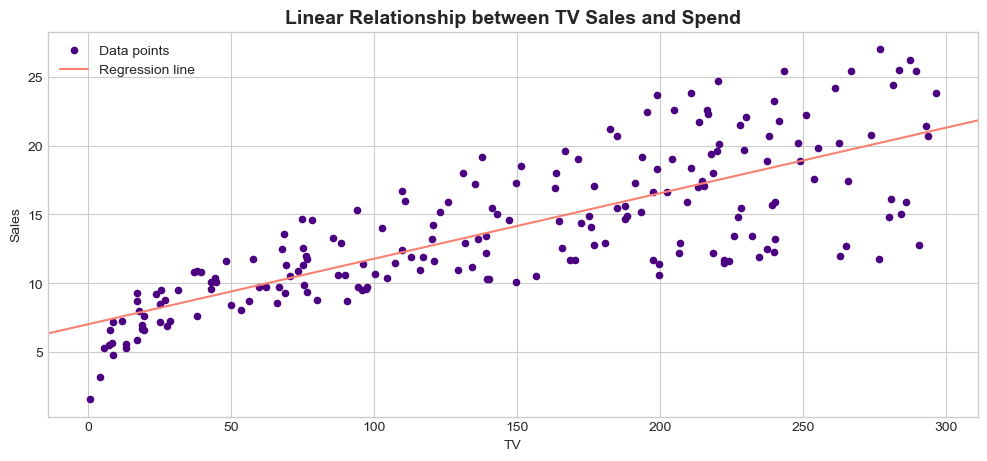

In [272]:
fig, ax = plt.subplots(figsize = (12, 5))
df_ad.plot.scatter(x = "TV", y = "Sales", label = "Data points", color = "#4b0082", ax = ax)
sm.graphics.abline_plot(model_results = results, label = "Regression line", color = "#fa8072", ax = ax)
ax.set_title("Linear Relationship between TV Sales and Spend", fontsize = 14, weight = 'bold')
ax.legend();

### Visualising TV Model Residuals

In [273]:
# Getting model residuals
print("=======TV Model Residuals=======")
results.resid

=======TV Model Residuals=======


1      4.129225
2      1.252026
3      1.449776
4      4.265605
5     -2.727218
         ...   
196   -1.248493
197   -1.810545
198   -2.646579
199    4.986015
200   -4.665848
Length: 200, dtype: float64

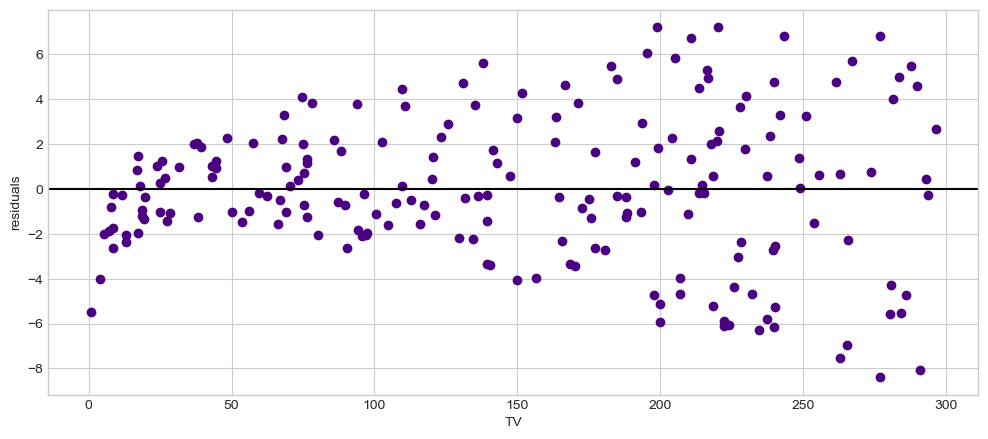

In [288]:
# Visualising the residuals
fig, ax = plt.subplots(figsize = (12, 5))

ax.scatter(df_ad["TV"], results.resid, color = '#4b0082')
ax.axhline(y = 0, color = "black")
ax.set_xlabel("TV")
ax.set_ylabel("residuals");

### TV Model Evaluation and Interpretation

#### *Model Evaluation*

In [275]:
# F-Statistic, p-value, R-Squared, and model parameters
print("==========MODEL EVALUATION CRITERIA===========")
print("\nF-statistic:", results.fvalue)
print("p-value:", results.f_pvalue)
print("R-Squared:", results.rsquared)
print("\nModel Parameters:\n", results.params)

==========MODEL EVALUATION CRITERIA===========

F-statistic: 312.144994372713
p-value: 1.4673897001946473e-42
R-Squared: 0.611875050850071

Model Parameters:
 const    7.032594
TV       0.047537
dtype: float64


#### *Interpretation:*

- Overall the model and coefficients are statistically significant, with all p-values well below a standard alpha of 0.05.

- The R-squared value is about 0.61 i.e. 61% of the variance in the target variable can be explained by TV spending.

- The intercept is about 7.0, meaning that if we spent 0 on TV, we would expect sales of about 7k widgets (the units of sales are in thousands of widgets).

- The TV coefficient is about 0.05, meaning that for each additional $1k spent on TV (the units of TV are in thousands of dollars), we would expect to sell an additional 50 widgets. (More precisely, 47.5 widgets.)

- All of these coefficients represent associations rather than causation. It's possible that better sales are what leads to more TV spending! Either way, TV seems to have a strong relationship with sales.

## Radio
### Simple Linear Regression with Radio as the Predictor

In [277]:
# Get regression line using Least Squares Method

# Calculate the correlation coefficient
rho = np.corrcoef(df_ad["Sales"], df_ad["Radio"])[0][1]

# Calculate standard deviations and slope
s_y = df_ad["Sales"].std()
s_x = df_ad["Radio"].std()
m = rho * s_y / s_x

# Calculate the intercept
mean_y = df_ad["Sales"].mean()
mean_x = df_ad["Radio"].mean()
c = mean_y - m * mean_x

print(f"Radio Regression line: y = {round(m, 5)}x + {round(c, 5)}")

Radio Regression line: y = 0.2025x + 9.31164


In [ ]:
# Define X and y
X = df_ad['Radio']
y = df_ad['Sales']

# Create OLS model
tabiri2 = sm.OLS(endog = y, exog = sm.add_constant(X))

# Fit the model
results2 = tabiri2.fit()

# Get model results summary
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           4.35e-19
Time:                        22:24:41   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3116      0.563     16.542      0.0

### Radio Model Visualisation

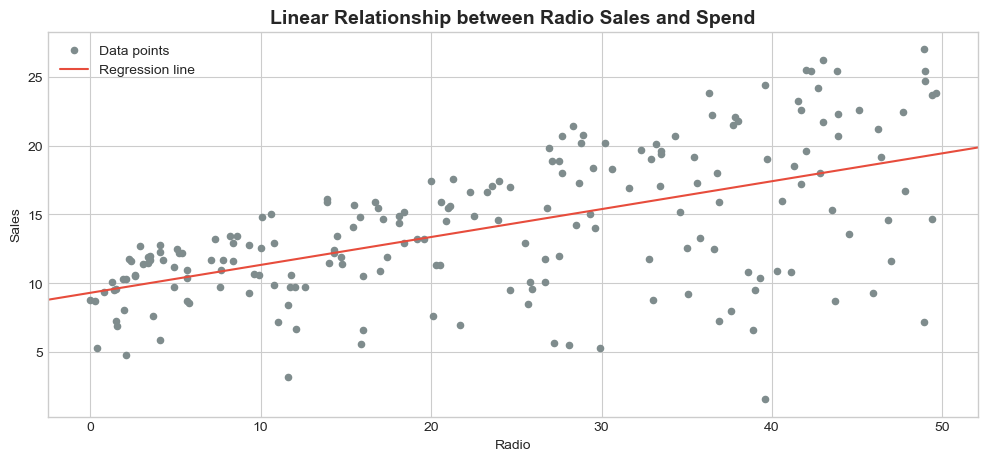

In [279]:
fig, ax = plt.subplots(figsize = (12, 5))
df_ad.plot.scatter(x = "Radio", y = "Sales", label = "Data points", color = "#7f8c8d", ax = ax)
sm.graphics.abline_plot(model_results = results2, label = "Regression line", color = "#e74c3c", ax = ax)
ax.set_title("Linear Relationship between Radio Sales and Spend", fontsize = 14, weight = 'bold')
ax.legend();

### Visualising Radio Model Residuals

In [ ]:
# Getting residuals
print("=======Radio Model Residuals=======")
results2.resid

=======Radio Model Residuals=======


1      5.134021
2     -6.869722
3     -9.306195
4      0.825286
5      1.401407
         ...   
196   -2.460872
197   -0.603867
198    1.605151
199    7.683539
200    2.346898
Length: 200, dtype: float64

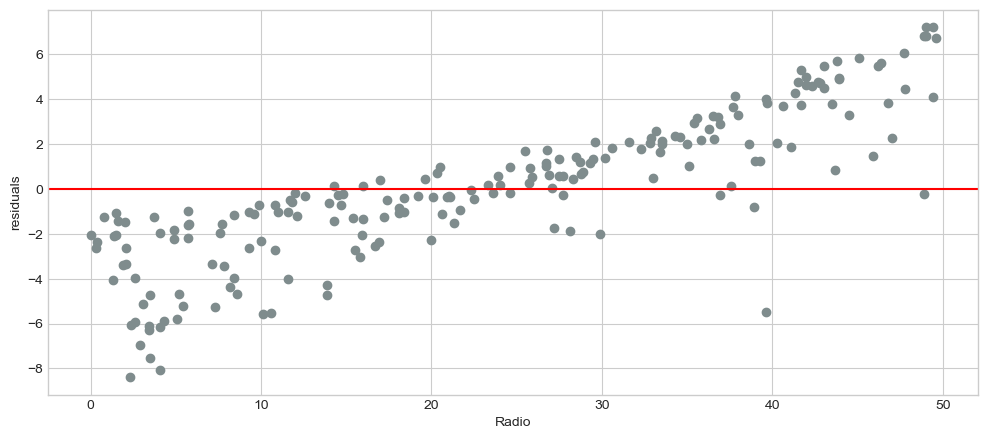

In [287]:
# Visualising the residuals
fig, ax = plt.subplots(figsize = (12, 5))

ax.scatter(df_ad["Radio"], results.resid, color = '#7f8c8d')
ax.axhline(y = 0, color = "red")
ax.set_xlabel("Radio")
ax.set_ylabel("residuals");

### Radio Model Evaluation & Interpretation
#### *Model Evaluation*

In [282]:
# F-Statistic, p-value, R-Squared, and model parameters
print("==========MODEL EVALUATION CRITERIA===========")
print("\nF-statistic:", results2.fvalue)
print("p-value:", results2.f_pvalue)
print("R-Squared:", results2.rsquared)
print("\nModel Parameters:\n", results2.params)

==========MODEL EVALUATION CRITERIA===========

F-statistic: 98.42158756679586
p-value: 4.35496600176671e-19
R-Squared: 0.33203245544529536

Model Parameters:
 const    9.311638
Radio    0.202496
dtype: float64


#### *Interpretation*

- Same as with TV, the radio model *is* statistically significant (p-values well below 0.05).

- However, this model explains less of the variance. It only explains about 33% of the variance in sales, compared to about 61% explained by TV. If our main focus is the percentage of variance explained, this is a worse model than the TV model.

- On the other hand, the coefficient for Radio is much higher. An increase of $1k in radio spending is associated with an increase of sales of about 200 widgets! This is roughly 4x the increase of widget sales that we see for TV.

- Visualizing this model, it doesn't look much different from the TV model.

## Newspaper
### Simple Linear Regression with Newspaper as the Predictor

In [283]:
# Get regression line using Least Squares Method

# Calculate the correlation coefficient
rho = np.corrcoef(df_ad["Sales"], df_ad["Newspaper"])[0][1]

# Calculate standard deviations and slope
s_y = df_ad["Sales"].std()
s_x = df_ad["Newspaper"].std()
m = rho * s_y / s_x

# Calculate the intercept
mean_y = df_ad["Sales"].mean()
mean_x = df_ad["Newspaper"].mean()
c = mean_y - m * mean_x

print(f"Newspaper Regression line: y = {round(m, 5)}x + {round(c, 5)}")

Newspaper Regression line: y = 0.05469x + 12.35141


In [284]:
# Define X and y
X = df_ad['Newspaper']
y = df_ad['Sales']

# Create OLS model
tabiri3 = sm.OLS(endog = y, exog = sm.add_constant(X))

# Fit the model
results3 = tabiri3.fit()

# Get model results summary
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Wed, 23 Jul 2025   Prob (F-statistic):            0.00115
Time:                        22:27:06   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3514      0.621     19.876      0.0

#### Newspaper Model Visualisation

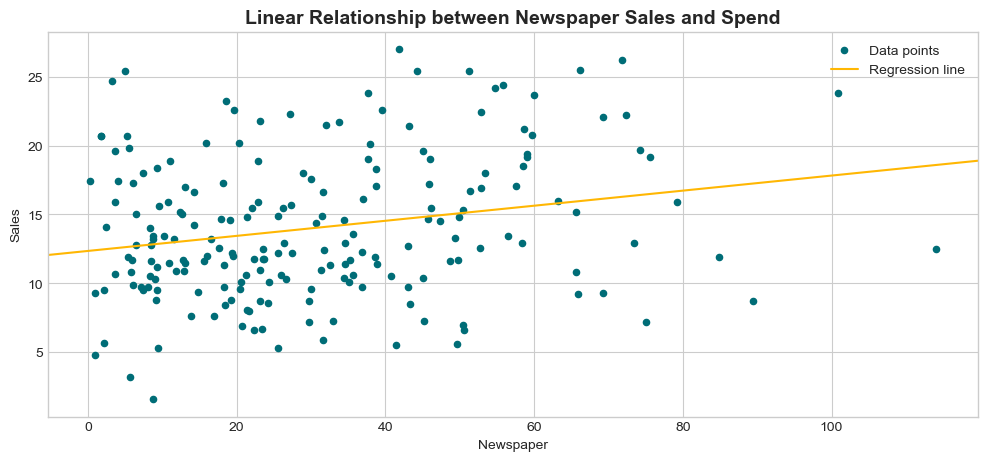

In [289]:
fig, ax = plt.subplots(figsize = (12, 5))
df_ad.plot.scatter(x = "Newspaper", y = "Sales", label = "Data points", color = "#006d77", ax = ax)
sm.graphics.abline_plot(model_results = results3, label = "Regression line", color = "#ffb703", ax = ax)
ax.set_title("Linear Relationship between Newspaper Sales and Spend", fontsize = 14, weight = 'bold')
ax.legend();

### Visualising Newspaper Model Residuals

In [291]:
# Getting residuals
print("=======Newspaper Model Residuals=======")
results3.resid

=======Newspaper Model Residuals=======


1      5.963831
2     -4.418066
3     -6.841639
4      2.949047
5     -2.645484
         ...   
196   -5.506172
197   -3.094421
198    0.098557
199    9.527910
200    0.572763
Length: 200, dtype: float64

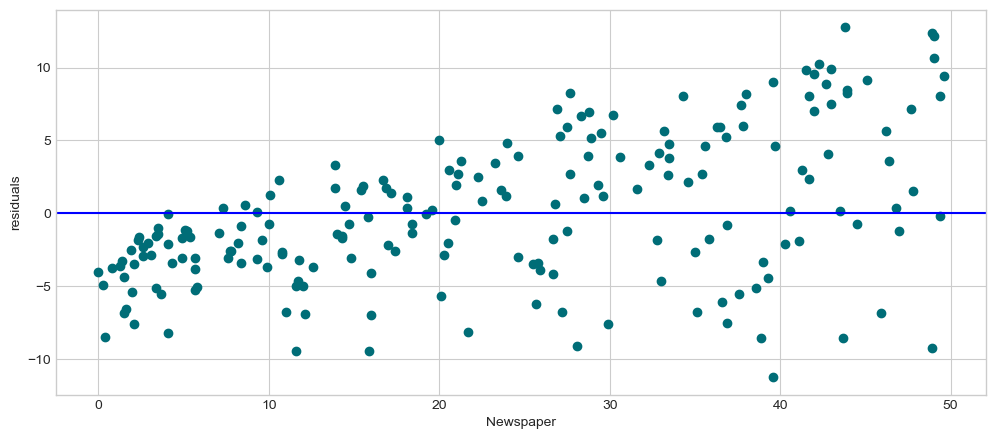

In [294]:
# Visualising the residuals
fig, ax = plt.subplots(figsize = (12, 5))

ax.scatter(df_ad["Radio"], results3.resid, color = '#006d77')
ax.axhline(y = 0, color = "b")
ax.set_xlabel("Newspaper")
ax.set_ylabel("residuals");

### Newspaper Model Evaluation & Interpretation
#### *Model Evaluation*

In [295]:
# F-Statistic, p-value, R-Squared, and model parameters
print("==========MODEL EVALUATION CRITERIA===========")
print("\nF-statistic:", results3.fvalue)
print("p-value:", results3.f_pvalue)
print("R-Squared:", results3.rsquared)
print("\nModel Parameters:\n", results3.params)

==========MODEL EVALUATION CRITERIA===========

F-statistic: 10.887299075471363
p-value: 0.0011481958688881913
R-Squared: 0.05212044544430516

Model Parameters:
 const        12.351407
Newspaper     0.054693
dtype: float64


#### *Interpretation*

- The model and its coefficients are still statistically significant at an alpha of 0.05, but the p-values are much higher. For both the F-statistic (overall model significance) and the newspaper coefficient, the p-values are about 0.001, meaning that there is about a 0.1% chance that a variable with no linear relationship would produce these statistics. However small this false positive value, it is still statistically significant!

- The R-Squared here is the smallest we have seen yet: 0.05. This means that the model explains about 5% of the variance in sales. 5% is well below both the radio model (33%) and the TV model (61%).

- The coefficient is also small, though similar to the TV coefficient. An increase of $1k in newspaper spending is associated with about 50 additional widget sales (more precisely, about 54.7). This is still much less than the 200-widget increase associated with $1k of additional radio spending.

- Visualizing this model, the best-fit line is clearly not a strong predictor. On the other hand, the residuals exhibit homoscedasticity, meaning that the distribution of the residuals doesn't vary much based on the value of newspaper. This contrasts with the radio and TV residuals which exhibit a "cone" shape, where the errors are larger as the x-axis increases.

-  Regardless of the framing, it is unlikely that newspaper is the answer to our question. This model has neither the highest R-Squared nor the highest coefficient.